# End-to-End Trading System Simulation

This notebook demonstrates a complete quantitative trading system implementation with:
- **Market Data Loading**: Real-time and historical data integration
- **Order Management System (OMS)**: Order processing and validation
- **Limit Order Book**: Market simulation and execution engine
- **Position Tracking**: Portfolio management and P&L calculation
- **Trading Strategies**: Trend Following, Mean Reversion, and Cross-Asset Arbitrage

## System Architecture

```
MarketDataLoader → Strategy → OMS → OrderBook → PositionTracker
      ↓              ↓         ↓       ↓           ↓
   Real Data    Signals   Orders  Executions   P&L/Blotter
```

## 1. Imports & System Instantiations

In [16]:
# Core system imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import warnings
from market_data_loader import MarketDataLoader
from oms import OrderManagementSystem
from order_book import LimitOrderBook
from order import Order
from position_tracker import PositionTracker
from strategies.trend_following import run_backtest as tf_backtest
from strategies.mean_reversion import run_backtest as mr_backtest
from strategies.arbitrage import run_backtest as arb_backtest

In [17]:
loader = MarketDataLoader(interval="1d", period="2y")

oms = OrderManagementSystem()

tracker = PositionTracker(starting_cash=100000.0)

book_aapl = LimitOrderBook("AAPL")
book_btc = LimitOrderBook("BTC-USD")
book_msft = LimitOrderBook("MSFT")

oms.matching_engine = book_aapl

## 2. Fetch Market Data & Generate Signals

### Load Historical Data for Multiple Assets

In [18]:
# Define date range for backtesting
end_date = "2025-07-28"
start_date = "2024-07-28"  # 1 year of data

try:
    # Apple stock data
    aapl_data = loader.get_history("AAPL", start=start_date, end=end_date)
    
    # Bitcoin data  
    btc_data = loader.get_history("BTC-USD", start=start_date, end=end_date)
    
    # Microsoft stock data
    msft_data = loader.get_history("MSFT", start=start_date, end=end_date)
    
    aapl_prices = aapl_data[('last_price', 'AAPL')]
    btc_prices = btc_data[('last_price', 'BTC-USD')]
    msft_prices = msft_data[('last_price', 'MSFT')]
    
except Exception as e:
    import traceback
    traceback.print_exc()

In [19]:
# Prepare data for strategies (flatten multi-level columns if needed)
def prepare_data(data, symbol):
    """Prepare market data for strategy consumption"""
    data_reset = data.reset_index()
    data_reset = data_reset.rename(columns={'Date': 'timestamp'})
    
    # Flatten multi-level columns if needed
    if isinstance(data_reset.columns, pd.MultiIndex):
        data_reset.columns = [col[0] if col[0] else 'timestamp' for col in data_reset.columns]
    
    return pd.DataFrame({
        'timestamp': data_reset['timestamp'],
        'last_price': data_reset['last_price']
    })

# Prepare data for all assets
aapl_history = prepare_data(aapl_data, "AAPL")
btc_history = prepare_data(btc_data, "BTC-USD")
msft_history = prepare_data(msft_data, "MSFT")

## 3. Strategy Execution & Signal Generation

### Strategy 1: Trend Following (Moving Average Crossover)

In [20]:
# STRATEGY 1: TREND FOLLOWING
# Asset: Bitcoin (BTC-USD)
# Method: Moving Average Crossover (10-day vs 50-day)

# Trend following parameters
tf_params = {
    'starting_cash': 100000.0,
    'position_size': 1.0,  # 1 BTC
    'short_win': 10,      # 10-day MA
    'long_win': 50,       # 50-day MA
    'transaction_cost': 0.001  # 0.1%
}

# Execute trend following backtest
tf_signals, tf_trades, tf_metrics = tf_backtest(btc_history, tf_params, 'BTC-USD')

# Buy & Hold comparison
btc_return = (btc_history['last_price'].iloc[-1] - btc_history['last_price'].iloc[0]) / btc_history['last_price'].iloc[0]

# Create results DataFrame
tf_results = pd.DataFrame({
    'Metric': [
        'Strategy Name',
        'Asset',
        'Method',
        'Total Return (%)',
        'Sharpe Ratio',
        'Max Drawdown (%)',
        'Number of Trades',
        'Final Value ($)',
        'Buy & Hold Return (%)',
        'Strategy vs B&H (%)'
    ],
    'Value': [
        'Trend Following',
        'Bitcoin (BTC-USD)',
        'Moving Average Crossover (10-day vs 50-day)',
        f"{tf_metrics['total_return']:.2%}",
        f"{tf_metrics['sharpe_ratio']:.2f}",
        f"{tf_metrics['max_drawdown']:.2%}",
        tf_metrics['num_trades'],
        f"${tf_metrics['final_cash']:,.2f}",
        f"{btc_return:.2%}",
        f"{tf_metrics['total_return'] - btc_return:.2%}"
    ]
})

tf_results

,Metric,Value
0,Strategy Name,Trend Following
1,Asset,Bitcoin (BTC-USD)
2,Method,Moving Average Crossover (10-day vs 50-day)
3,Total Return (%),6.69%
4,Sharpe Ratio,1.47
5,Max Drawdown (%),-105.70%
6,Number of Trades,8
7,Final Value ($),"$106,685.21"
8,Buy & Hold Return (%),75.00%
9,Strategy vs B&H (%),-68.32%


### Strategy 2: Mean Reversion (Bollinger Bands)

In [8]:
# STRATEGY 2: MEAN REVERSION
# Asset: Apple Inc. (AAPL)
# Method: Bollinger Bands (20-day, 2 std dev)

mr_params = {
    'starting_cash': 100000.0,
    'position_size': 10,      # 10 shares
    'bollinger_win': 20,      # 20-day window
    'num_std': 2.0,          # 2 standard deviations
    'transaction_cost': 0.001 # 0.1%
}

# Execute mean reversion backtest
mr_signals, mr_trades, mr_metrics = mr_backtest(aapl_history, mr_params, 'AAPL')

# Buy & Hold comparison
aapl_return = (aapl_history['last_price'].iloc[-1] - aapl_history['last_price'].iloc[0]) / aapl_history['last_price'].iloc[0]

# Create results DataFrame
mr_results = pd.DataFrame({
    'Metric': [
        'Strategy Name',
        'Asset',
        'Method',
        'Total Return (%)',
        'Sharpe Ratio',
        'Max Drawdown (%)',
        'Number of Trades',
        'Final Value ($)',
        'Buy & Hold Return (%)',
        'Strategy vs B&H (%)'
    ],
    'Value': [
        'Mean Reversion',
        'Apple Inc. (AAPL)',
        'Bollinger Bands (20-day, 2 std dev)',
        f"{mr_metrics['total_return']:.2%}",
        f"{mr_metrics['sharpe_ratio']:.2f}",
        f"{mr_metrics['max_drawdown']:.2%}",
        mr_metrics['num_trades'],
        f"${mr_metrics['final_cash']:,.2f}",
        f"{aapl_return:.2%}",
        f"{mr_metrics['total_return'] - aapl_return:.2%}"
    ]
})

# Display the results
mr_results

,Metric,Value
0,Strategy Name,Mean Reversion
1,Asset,Apple Inc. (AAPL)
2,Method,"Bollinger Bands (20-day, 2 std dev)"
3,Total Return (%),-0.20%
4,Sharpe Ratio,1.17
5,Max Drawdown (%),-2.36%
6,Number of Trades,12
7,Final Value ($),"$99,797.53"
8,Buy & Hold Return (%),-1.54%
9,Strategy vs B&H (%),1.34%


### Strategy 3: Cross-Asset Arbitrage (Pairs Trading)

In [21]:
# STRATEGY 3: CROSS-ASSET ARBITRAGE
# Assets: Apple Inc. (AAPL) vs Microsoft Corp. (MSFT)
# Method: Pairs Trading with Rolling Hedge Ratio

# Arbitrage parameters
arb_params = {
    'starting_cash': 100000.0,
    'position_size': 10,         # 10 shares each
    'threshold': 2.0,           # 2 standard deviations
    'transaction_cost': 0.001,  # 0.1%
    'lookback_window': 30       # 30-day rolling window
}

# Execute arbitrage backtest
arb_signals, arb_trades, arb_metrics = arb_backtest(aapl_history, msft_history, arb_params, 'AAPL', 'MSFT')

# Equal weight portfolio comparison
msft_return = (msft_history['last_price'].iloc[-1] - msft_history['last_price'].iloc[0]) / msft_history['last_price'].iloc[0]
equal_weight = (aapl_return + msft_return) / 2

# Create results DataFrame
arb_results = pd.DataFrame({
    'Metric': [
        'Strategy Name',
        'Assets',
        'Method',
        'Total Return (%)',
        'Sharpe Ratio',
        'Max Drawdown (%)',
        'Number of Trades',
        'Pairs Traded',
        'Transaction Costs ($)',
        'Final Value ($)',
        'Equal Weight Portfolio (%)',
        'Strategy vs Equal Weight (%)'
    ],
    'Value': [
        'Cross-Asset Arbitrage',
        'Apple Inc. (AAPL) vs Microsoft Corp. (MSFT)',
        'Pairs Trading with Rolling Hedge Ratio',
        f"{arb_metrics['total_return']:.2%}",
        f"{arb_metrics['sharpe_ratio']:.2f}",
        f"{arb_metrics['max_drawdown']:.2%}",
        arb_metrics['num_trades'],
        arb_metrics['num_pairs_traded'],
        f"${arb_metrics['transaction_costs']:,.2f}",
        f"${arb_metrics['final_cash']:,.2f}",
        f"{equal_weight:.2%}",
        f"{arb_metrics['total_return'] - equal_weight:.2%}"
    ]
})

# Display the results
arb_results

,Metric,Value
0,Strategy Name,Cross-Asset Arbitrage
1,Assets,Apple Inc. (AAPL) vs Microsoft Corp. (MSFT)
2,Method,Pairs Trading with Rolling Hedge Ratio
3,Total Return (%),-0.60%
4,Sharpe Ratio,0.19
5,Max Drawdown (%),-9.70%
6,Number of Trades,44
7,Pairs Traded,22
8,Transaction Costs ($),$142.77
9,Final Value ($),"$99,399.13"


## 4. Simulate Orders & Executions

### Execute  Orders Through Trading System

In [22]:
# Reset tracker for clean execution tracking
sim_tracker = PositionTracker(starting_cash=100000.0)
executed_orders = []
execution_reports = []

# Function to process strategy trades without simulation
def process_trade_signal(trade, strategy_name):
    """Process trade signal as-is from strategy"""
    execution_report = {
        "order_id": f"{strategy_name}_{len(execution_reports)+1:03d}",
        "symbol": trade['symbol'],
        "side": trade['side'],
        "filled_qty": abs(trade['quantity']),
        "price": trade['price'],  # Use exact strategy price
        "timestamp": trade.get('timestamp', pd.Timestamp.now())
    }
    return execution_report

# Process Trend Following trades
tf_executions = 0
for i, trade in enumerate(tf_trades[:10]):  # Show first 10 trades
    try:
        execution_report = process_trade_signal(trade, "TF")
        sim_tracker.update(execution_report)
        execution_reports.append(execution_report)
        tf_executions += 1
        
    except Exception as e:
        pass

# Process Mean Reversion trades
mr_executions = 0
for i, trade in enumerate(mr_trades[:10]):  # Show first 10 trades
    try:
        execution_report = process_trade_signal(trade, "MR")
        sim_tracker.update(execution_report)
        execution_reports.append(execution_report)
        mr_executions += 1
        
    except Exception as e:
        pass

# Process Arbitrage trades
arb_executions = 0
for i, trade in enumerate(arb_trades[:15]):  # Show first 15 trades
    try:
        execution_report = process_trade_signal(trade, "ARB")
        sim_tracker.update(execution_report)
        execution_reports.append(execution_report)
        arb_executions += 1
        
    except Exception as e:
        pass

## 5. Compile and Plot P&L

### Generate Equity Curves and Performance Analytics

In [23]:
# Get blotter from position tracker with executed trades
blotter = sim_tracker.get_blotter()

if len(blotter) > 0:
    # Calculate cumulative P&L
    blotter["cum_pnl"] = blotter["cash_flow"].cumsum()
    blotter["equity"] = 100000.0 + blotter["cum_pnl"]  # Starting cash + cumulative P&L
    
    # Strategy breakdown by symbol
    btc_trades = blotter[blotter['symbol'] == 'BTC-USD']
    aapl_trades = blotter[blotter['symbol'] == 'AAPL']
    msft_trades = blotter[blotter['symbol'] == 'MSFT']
    
    # Create DataFrame with execution results metrics
    execution_results = pd.DataFrame({
        'Metric': [
            'Total Trades Executed',
            'Starting Capital ($)',
            'Final Equity ($)',
            'Total P&L ($)',
            'Total Return (%)',
            'Average P&L per Trade ($)',
            'Current Cash ($)',
            'BTC-USD Trades',
            'AAPL Trades', 
            'MSFT Trades',
            'Winning Trades',
            'Losing Trades'
        ],
        'Value': [
            len(blotter),
            f"${100000:,.2f}",
            f"${blotter['equity'].iloc[-1]:,.2f}",
            f"${blotter['cum_pnl'].iloc[-1]:,.2f}",
            f"{(blotter['equity'].iloc[-1] - 100000) / 100000:.2%}",
            f"${blotter['cash_flow'].mean():,.2f}",
            f"${sim_tracker.cash:,.2f}",
            len(btc_trades),
            len(aapl_trades),
            len(msft_trades),
            len(blotter[blotter['cash_flow'] > 0]),
            len(blotter[blotter['cash_flow'] < 0])
        ]
    })
    
    # Create comprehensive blotter DataFrame with all trade records
    blotter_records = blotter.copy()
    
    # Add additional columns for better analysis
    blotter_records['trade_number'] = range(1, len(blotter_records) + 1)
    blotter_records['profit_loss'] = blotter_records['cash_flow'].apply(lambda x: 'Profit' if x > 0 else 'Loss')
    blotter_records['asset_class'] = blotter_records['symbol'].map({
        'BTC-USD': 'Cryptocurrency',
        'AAPL': 'Technology Stock',
        'MSFT': 'Technology Stock'
    })
    
    # Reorder columns for better readability
    blotter_records = blotter_records[[
        'trade_number', 'timestamp', 'symbol', 'asset_class', 'side', 
        'quantity', 'price', 'cash_flow', 'profit_loss', 'cum_pnl', 'equity'
    ]]
    
else:
    blotter_records = pd.DataFrame()  # Empty DataFrame if no trades
    execution_results = pd.DataFrame()  # Empty DataFrame if no trades

# Display the execution results metrics
display(execution_results)

# Display the detailed trade records
blotter_records

,Metric,Value
0,Total Trades Executed,33
1,Starting Capital ($),"$100,000.00"
2,Final Equity ($),"$102,419.88"
3,Total P&L ($),"$2,419.88"
4,Total Return (%),2.42%
5,Average P&L per Trade ($),$73.33
6,Current Cash ($),"$102,419.88"
7,BTC-USD Trades,8
8,AAPL Trades,18
9,MSFT Trades,7


,trade_number,timestamp,symbol,asset_class,side,quantity,price,cash_flow,profit_loss,cum_pnl,equity
0,1,2024-09-19 00:00:00+00:00,BTC-USD,Cryptocurrency,buy,1.0,62940.457031,-62940.457031,Loss,-62940.457031,37059.542969
1,2,2024-09-20 00:00:00+00:00,BTC-USD,Cryptocurrency,sell,1.0,63192.976562,63192.976562,Profit,252.519531,100252.519531
2,3,2025-01-19 00:00:00+00:00,BTC-USD,Cryptocurrency,buy,1.0,101089.609375,-101089.609375,Loss,-100837.089844,-837.089844
3,4,2025-01-20 00:00:00+00:00,BTC-USD,Cryptocurrency,sell,1.0,102016.664062,102016.664062,Profit,1179.574219,101179.574219
4,5,2025-04-20 00:00:00+00:00,BTC-USD,Cryptocurrency,buy,1.0,85174.304688,-85174.304688,Loss,-83994.730469,16005.269531
5,6,2025-04-21 00:00:00+00:00,BTC-USD,Cryptocurrency,sell,1.0,87518.906250,87518.906250,Profit,3524.175781,103524.175781
6,7,2025-07-01 00:00:00+00:00,BTC-USD,Cryptocurrency,buy,1.0,105698.281250,-105698.281250,Loss,-102174.105469,-2174.105469
7,8,2025-07-02 00:00:00+00:00,BTC-USD,Cryptocurrency,sell,1.0,108859.320312,108859.320312,Profit,6685.214844,106685.214844
8,9,2024-09-16 00:00:00+00:00,AAPL,Technology Stock,buy,10.0,215.562286,-2155.622864,Loss,4529.591980,104529.591980
9,10,2024-09-17 00:00:00+00:00,AAPL,Technology Stock,sell,10.0,216.030609,2160.306091,Profit,6689.898071,106689.898071


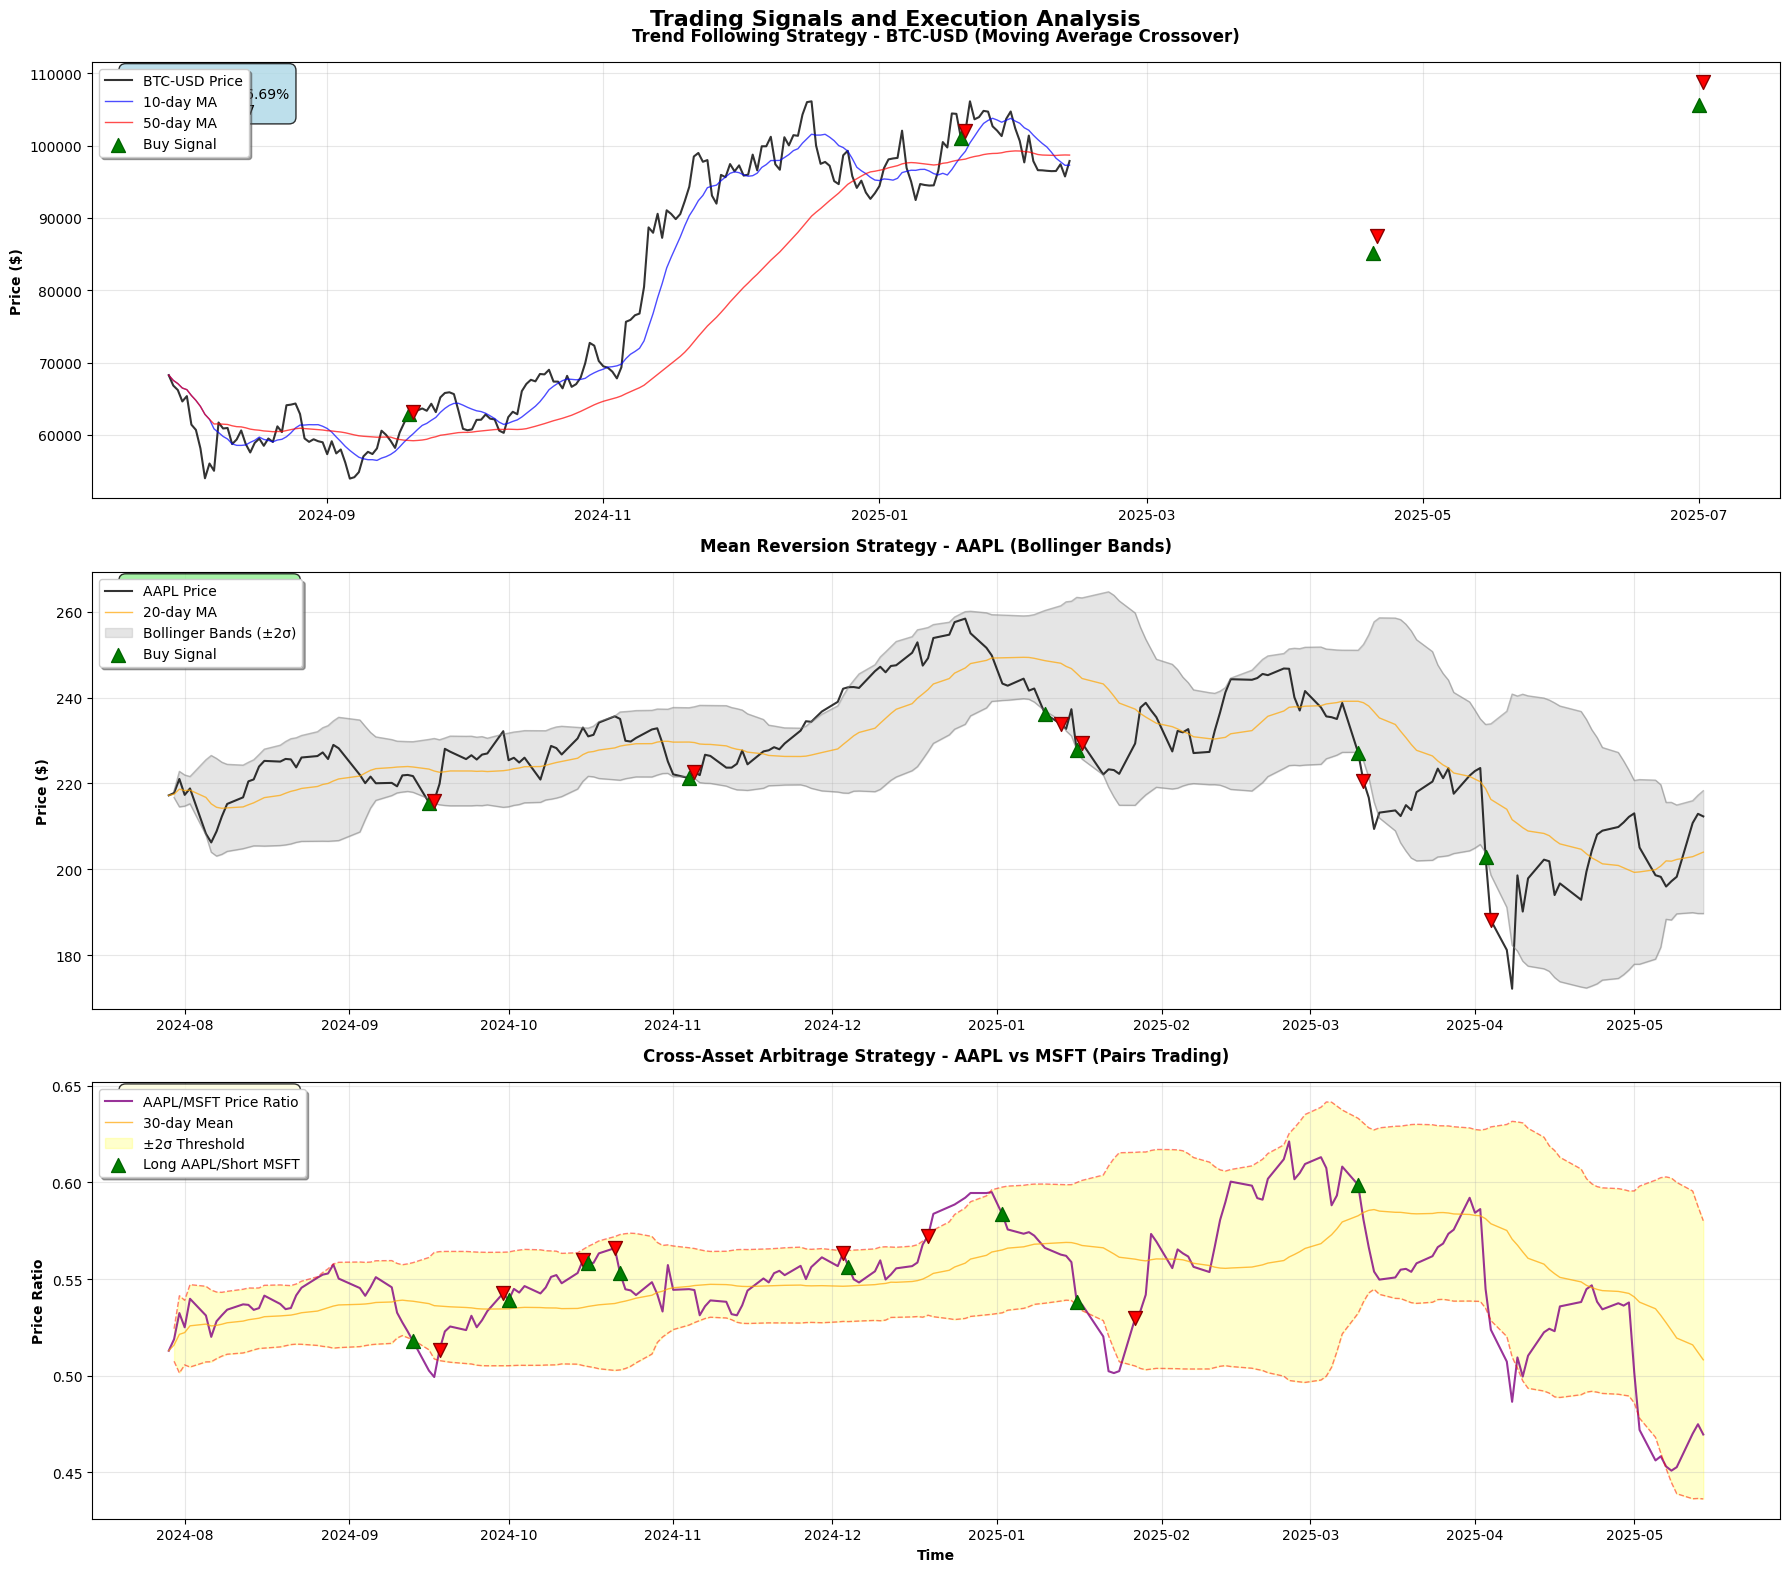


TRADE EXECUTION TIMELINE SUMMARY

EXECUTION SUMMARY BY STRATEGY:
                              filled_qty     price  trade_count
strategy        symbol  side                                   
Arbitrage       AAPL    buy         40.0    228.29            4
                        sell        40.0    230.20            4
                MSFT    buy         40.0    422.19            4
                        sell        30.0    420.01            3
Mean Reversion  AAPL    buy         50.0    225.59            5
                        sell        50.0    224.50            5
Trend Following BTC-USD buy          4.0  88725.66            4
                        sell         4.0  90396.97            4

TOTAL EXECUTED TRADES: 33
STRATEGIES ACTIVE: 3
ASSETS TRADED: 3


In [24]:
# TRADING SIGNALS VISUALIZATION
# Create comprehensive charts showing price data, signals, and trade execution points

fig, axes = plt.subplots(3, 1, figsize=(18, 16))
fig.suptitle('Trading Signals and Execution Analysis', fontsize=16, fontweight='bold', y=0.98)

# 1. TREND FOLLOWING STRATEGY - BTC-USD
ax1 = axes[0]

# Plot BTC price data
btc_prices = btc_history['last_price'].iloc[:200]  # First 200 days for clarity
btc_dates = btc_history['timestamp'].iloc[:200] if 'timestamp' in btc_history.columns else range(len(btc_prices))

ax1.plot(btc_dates, btc_prices, 'k-', linewidth=1.5, label='BTC-USD Price', alpha=0.8)

# Calculate and plot moving averages
short_ma = btc_prices.rolling(window=10, min_periods=1).mean()
long_ma = btc_prices.rolling(window=50, min_periods=1).mean()

ax1.plot(btc_dates, short_ma, 'b-', linewidth=1, label='10-day MA', alpha=0.7)
ax1.plot(btc_dates, long_ma, 'r-', linewidth=1, label='50-day MA', alpha=0.7)

# Plot trade signals from strategy
if len(tf_trades) > 0:
    for i, trade in enumerate(tf_trades[:20]):  # First 20 trades
        try:
            # Find corresponding price point
            trade_timestamp = trade.get('timestamp')
            trade_price = trade['price']
            
            if trade['side'] == 'buy':
                ax1.scatter(trade_timestamp, trade_price, color='green', s=100, marker='^', 
                           label='Buy Signal' if i == 0 else "", zorder=5, edgecolors='darkgreen', linewidth=1)
            else:
                ax1.scatter(trade_timestamp, trade_price, color='red', s=100, marker='v', 
                           label='Sell Signal' if i == 0 else "", zorder=5, edgecolors='darkred', linewidth=1)
        except:
            continue

ax1.set_title('Trend Following Strategy - BTC-USD (Moving Average Crossover)', fontweight='bold', pad=15)
ax1.set_ylabel('Price ($)', fontweight='bold')
ax1.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3)

# Add performance annotation
if len(tf_trades) > 0:
    ax1.text(0.02, 0.98, f"Total Trades: {len(tf_trades)}\nStrategy Return: {tf_metrics['total_return']:.2%}\nSharpe Ratio: {tf_metrics['sharpe_ratio']:.2f}", 
             transform=ax1.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))

# 2. MEAN REVERSION STRATEGY - AAPL
ax2 = axes[1]

# Plot AAPL price data
aapl_prices = aapl_history['last_price'].iloc[:200]  # First 200 days
aapl_dates = aapl_history['timestamp'].iloc[:200] if 'timestamp' in aapl_history.columns else range(len(aapl_prices))

ax2.plot(aapl_dates, aapl_prices, 'k-', linewidth=1.5, label='AAPL Price', alpha=0.8)

# Calculate and plot Bollinger Bands
rolling_mean = aapl_prices.rolling(window=20, min_periods=1).mean()
rolling_std = aapl_prices.rolling(window=20, min_periods=1).std()
upper_band = rolling_mean + (2 * rolling_std)
lower_band = rolling_mean - (2 * rolling_std)

ax2.plot(aapl_dates, rolling_mean, 'orange', linewidth=1, label='20-day MA', alpha=0.7)
ax2.fill_between(aapl_dates, upper_band, lower_band, alpha=0.2, color='gray', label='Bollinger Bands (±2σ)')
ax2.plot(aapl_dates, upper_band, 'gray', linewidth=1, alpha=0.5)
ax2.plot(aapl_dates, lower_band, 'gray', linewidth=1, alpha=0.5)

# Plot trade signals
if len(mr_trades) > 0:
    for i, trade in enumerate(mr_trades[:20]):  # First 20 trades
        try:
            trade_timestamp = trade.get('timestamp')
            trade_price = trade['price']
            
            if trade['side'] == 'buy':
                ax2.scatter(trade_timestamp, trade_price, color='green', s=100, marker='^', 
                           label='Buy Signal' if i == 0 else "", zorder=5, edgecolors='darkgreen', linewidth=1)
            else:
                ax2.scatter(trade_timestamp, trade_price, color='red', s=100, marker='v', 
                           label='Sell Signal' if i == 0 else "", zorder=5, edgecolors='darkred', linewidth=1)
        except:
            continue

ax2.set_title('Mean Reversion Strategy - AAPL (Bollinger Bands)', fontweight='bold', pad=15)
ax2.set_ylabel('Price ($)', fontweight='bold')
ax2.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
ax2.grid(True, alpha=0.3)

# Add performance annotation
if len(mr_trades) > 0:
    ax2.text(0.02, 0.98, f"Total Trades: {len(mr_trades)}\nStrategy Return: {mr_metrics['total_return']:.2%}\nSharpe Ratio: {mr_metrics['sharpe_ratio']:.2f}", 
             transform=ax2.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))

# 3. ARBITRAGE STRATEGY - AAPL vs MSFT
ax3 = axes[2]

# Plot price ratio and spread
aapl_prices_arb = aapl_history['last_price'].iloc[:200]
msft_prices_arb = msft_history['last_price'].iloc[:200]
dates_arb = aapl_history['timestamp'].iloc[:200] if 'timestamp' in aapl_history.columns else range(len(aapl_prices_arb))

# Calculate price ratio
price_ratio = aapl_prices_arb / msft_prices_arb
ratio_mean = price_ratio.rolling(window=30, min_periods=1).mean()
ratio_std = price_ratio.rolling(window=30, min_periods=1).std()

ax3.plot(dates_arb, price_ratio, 'purple', linewidth=1.5, label='AAPL/MSFT Price Ratio', alpha=0.8)
ax3.plot(dates_arb, ratio_mean, 'orange', linewidth=1, label='30-day Mean', alpha=0.7)

# Plot threshold bands
upper_threshold = ratio_mean + (2 * ratio_std)
lower_threshold = ratio_mean - (2 * ratio_std)
ax3.fill_between(dates_arb, upper_threshold, lower_threshold, alpha=0.2, color='yellow', label='±2σ Threshold')
ax3.plot(dates_arb, upper_threshold, 'red', linewidth=1, alpha=0.5, linestyle='--')
ax3.plot(dates_arb, lower_threshold, 'red', linewidth=1, alpha=0.5, linestyle='--')

# Plot arbitrage signals
if len(arb_trades) > 0:
    # Group trades by pairs (AAPL and MSFT trades should occur together)
    aapl_arb_trades = [t for t in arb_trades if t['symbol'] == 'AAPL'][:15]
    msft_arb_trades = [t for t in arb_trades if t['symbol'] == 'MSFT'][:15]
    
    for i, trade in enumerate(aapl_arb_trades):
        try:
            trade_timestamp = trade.get('timestamp')
            # Get ratio at trade time
            trade_idx = None
            if hasattr(trade_timestamp, 'date'):
                for j, date in enumerate(dates_arb):
                    if hasattr(date, 'date') and date.date() == trade_timestamp.date():
                        trade_idx = j
                        break
            
            if trade_idx is not None and trade_idx < len(price_ratio):
                ratio_value = price_ratio.iloc[trade_idx]
                
                if trade['side'] == 'buy':  # Long AAPL, Short MSFT
                    ax3.scatter(trade_timestamp, ratio_value, color='green', s=100, marker='^', 
                               label='Long AAPL/Short MSFT' if i == 0 else "", zorder=5, edgecolors='darkgreen', linewidth=1)
                else:  # Short AAPL, Long MSFT
                    ax3.scatter(trade_timestamp, ratio_value, color='red', s=100, marker='v', 
                               label='Short AAPL/Long MSFT' if i == 0 else "", zorder=5, edgecolors='darkred', linewidth=1)
        except:
            continue

ax3.set_title('Cross-Asset Arbitrage Strategy - AAPL vs MSFT (Pairs Trading)', fontweight='bold', pad=15)
ax3.set_ylabel('Price Ratio', fontweight='bold')
ax3.set_xlabel('Time', fontweight='bold')
ax3.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
ax3.grid(True, alpha=0.3)

# Add performance annotation
if len(arb_trades) > 0:
    ax3.text(0.02, 0.98, f"Total Trades: {len(arb_trades)}\nStrategy Return: {arb_metrics['total_return']:.2%}\nSharpe Ratio: {arb_metrics['sharpe_ratio']:.2f}", 
             transform=ax3.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# TRADE EXECUTION TIMELINE
print("\n" + "="*80)
print("TRADE EXECUTION TIMELINE SUMMARY")
print("="*80)

if len(execution_reports) > 0:
    # Create execution timeline DataFrame
    timeline_df = pd.DataFrame(execution_reports)
    
    # Add strategy mapping
    timeline_df['strategy'] = timeline_df['order_id'].apply(lambda x: 
        'Trend Following' if x.startswith('TF') else 
        'Mean Reversion' if x.startswith('MR') else 
        'Arbitrage')
    
    # Sort by timestamp
    timeline_df = timeline_df.sort_values('timestamp').reset_index(drop=True)
    
    # Display execution summary
    execution_summary = timeline_df.groupby(['strategy', 'symbol', 'side']).agg({
        'filled_qty': 'sum',
        'price': 'mean',
        'order_id': 'count'
    }).rename(columns={'order_id': 'trade_count'}).round(2)
    
    print("\nEXECUTION SUMMARY BY STRATEGY:")
    print(execution_summary)
    
    print(f"\nTOTAL EXECUTED TRADES: {len(timeline_df)}")
    print(f"STRATEGIES ACTIVE: {timeline_df['strategy'].nunique()}")
    print(f"ASSETS TRADED: {timeline_df['symbol'].nunique()}")
    
else:
    print("No trades executed in the simulation.")

print("="*80)

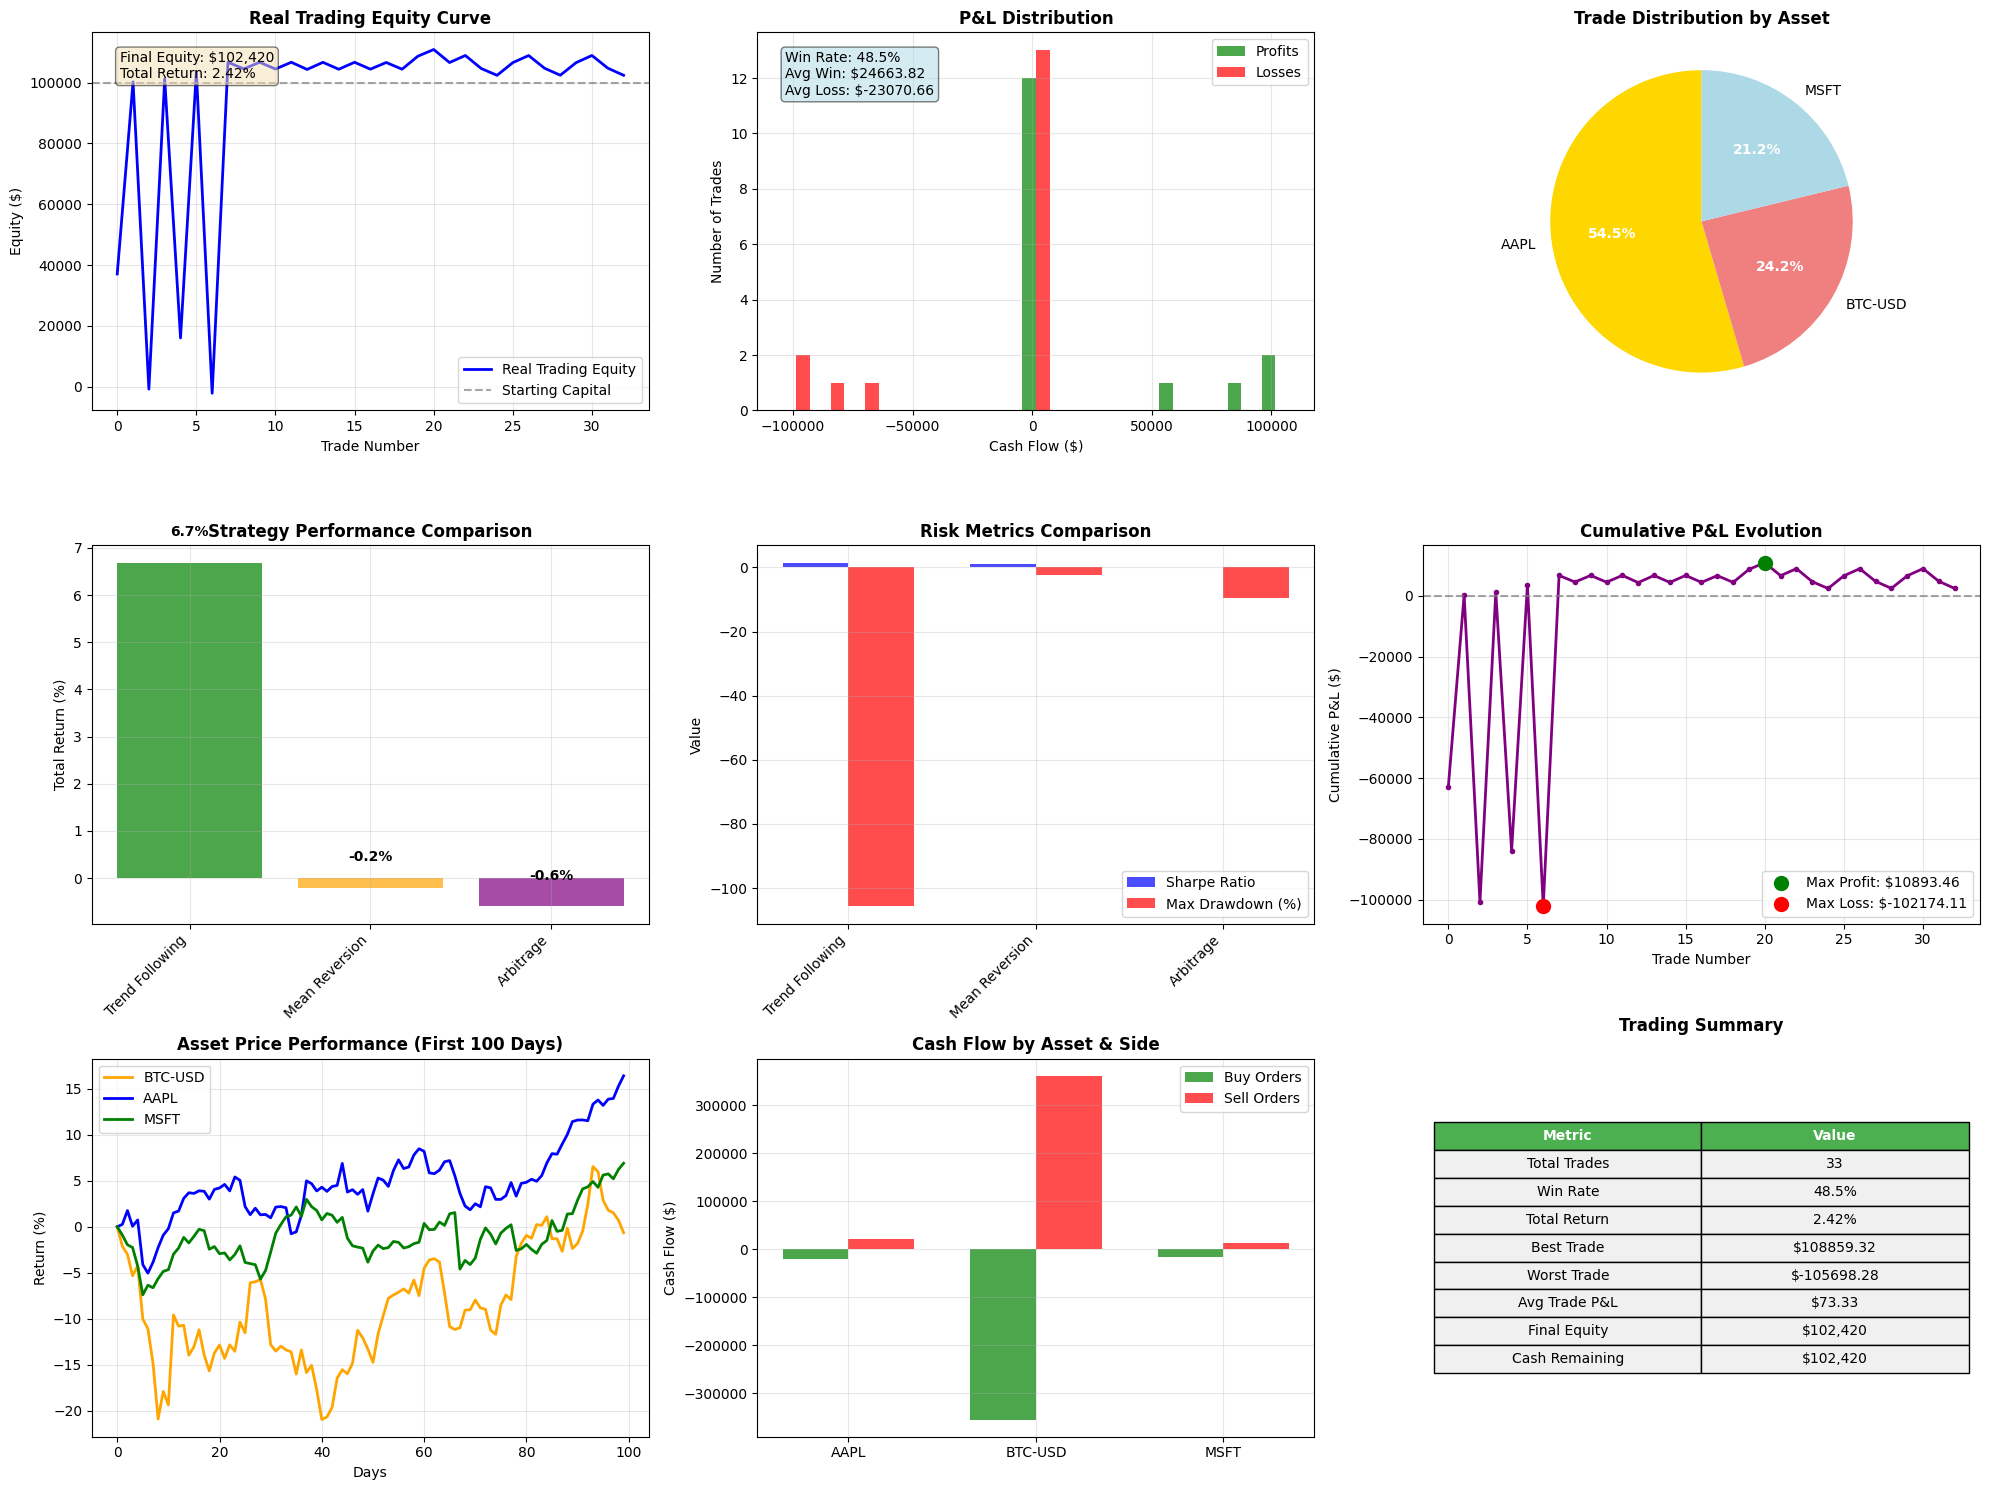

In [26]:


fig = plt.figure(figsize=(20, 15))

# 1. Real vs Simulated Performance Comparison (Top Left)
ax1 = plt.subplot(3, 3, 1)
if len(blotter) > 0:
    # Plot real trading equity curve
    ax1.plot(range(len(blotter)), blotter['equity'], 'b-', linewidth=2, label='Real Trading Equity')
    ax1.axhline(y=100000, color='gray', linestyle='--', alpha=0.7, label='Starting Capital')
    ax1.set_title('Real Trading Equity Curve', fontweight='bold')
    ax1.set_xlabel('Trade Number')
    ax1.set_ylabel('Equity ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add annotations
    final_equity = blotter['equity'].iloc[-1]
    total_return = (final_equity - 100000) / 100000
    ax1.text(0.05, 0.95, f'Final Equity: ${final_equity:,.0f}\nTotal Return: {total_return:.2%}', 
             transform=ax1.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. P&L Distribution (Top Center)
ax2 = plt.subplot(3, 3, 2)
if len(blotter) > 0:
    cash_flows = blotter['cash_flow']
    profits = cash_flows[cash_flows > 0]
    losses = cash_flows[cash_flows < 0]
    
    ax2.hist([profits, losses], bins=15, alpha=0.7, label=['Profits', 'Losses'], color=['green', 'red'])
    ax2.set_title('P&L Distribution', fontweight='bold')
    ax2.set_xlabel('Cash Flow ($)')
    ax2.set_ylabel('Number of Trades')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add statistics
    win_rate = len(profits) / len(cash_flows)
    avg_win = profits.mean() if len(profits) > 0 else 0
    avg_loss = losses.mean() if len(losses) > 0 else 0
    ax2.text(0.05, 0.95, f'Win Rate: {win_rate:.1%}\nAvg Win: ${avg_win:.2f}\nAvg Loss: ${avg_loss:.2f}', 
             transform=ax2.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# 3. Asset Allocation (Top Right)
ax3 = plt.subplot(3, 3, 3)
if len(blotter) > 0:
    asset_counts = blotter['symbol'].value_counts()
    colors = ['gold', 'lightcoral', 'lightblue']
    wedges, texts, autotexts = ax3.pie(asset_counts.values, labels=asset_counts.index, autopct='%1.1f%%', 
                                       colors=colors, startangle=90)
    ax3.set_title('Trade Distribution by Asset', fontweight='bold')
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

# 4. Strategy Performance Comparison (Middle Left)
ax4 = plt.subplot(3, 3, 4)
strategy_names = ['Trend Following', 'Mean Reversion', 'Arbitrage']
strategy_returns = [tf_metrics['total_return'], mr_metrics['total_return'], arb_metrics['total_return']]
colors = ['green', 'orange', 'purple']

bars = ax4.bar(strategy_names, [r * 100 for r in strategy_returns], color=colors, alpha=0.7)
ax4.set_title('Strategy Performance Comparison', fontweight='bold')
ax4.set_ylabel('Total Return (%)')
ax4.grid(True, alpha=0.3)
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# 5. Risk Metrics Comparison (Middle Center)
ax5 = plt.subplot(3, 3, 5)
sharpe_ratios = [tf_metrics['sharpe_ratio'], mr_metrics['sharpe_ratio'], arb_metrics['sharpe_ratio']]
max_drawdowns = [tf_metrics['max_drawdown'], mr_metrics['max_drawdown'], arb_metrics['max_drawdown']]

x = np.arange(len(strategy_names))
width = 0.35

bars1 = ax5.bar(x - width/2, sharpe_ratios, width, label='Sharpe Ratio', color='blue', alpha=0.7)
bars2 = ax5.bar(x + width/2, [dd * 100 for dd in max_drawdowns], width, label='Max Drawdown (%)', color='red', alpha=0.7)

ax5.set_title('Risk Metrics Comparison', fontweight='bold')
ax5.set_ylabel('Value')
ax5.set_xticks(x)
ax5.set_xticklabels(strategy_names, rotation=45, ha='right')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Cumulative P&L Over Time (Middle Right)
ax6 = plt.subplot(3, 3, 6)
if len(blotter) > 0:
    ax6.plot(range(len(blotter)), blotter['cum_pnl'], 'purple', linewidth=2, marker='o', markersize=3)
    ax6.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    ax6.set_title('Cumulative P&L Evolution', fontweight='bold')
    ax6.set_xlabel('Trade Number')
    ax6.set_ylabel('Cumulative P&L ($)')
    ax6.grid(True, alpha=0.3)
    
    # Highlight max profit and max loss
    max_profit = blotter['cum_pnl'].max()
    min_loss = blotter['cum_pnl'].min()
    max_idx = blotter['cum_pnl'].idxmax()
    min_idx = blotter['cum_pnl'].idxmin()
    
    ax6.scatter(max_idx, max_profit, color='green', s=100, zorder=5, label=f'Max Profit: ${max_profit:.2f}')
    ax6.scatter(min_idx, min_loss, color='red', s=100, zorder=5, label=f'Max Loss: ${min_loss:.2f}')
    ax6.legend()

# 7. Asset Price Performance (Bottom Left)
ax7 = plt.subplot(3, 3, 7)
# Normalize prices to show relative performance
btc_norm = (btc_history['last_price'] / btc_history['last_price'].iloc[0] - 1) * 100
aapl_norm = (aapl_history['last_price'] / aapl_history['last_price'].iloc[0] - 1) * 100
msft_norm = (msft_history['last_price'] / msft_history['last_price'].iloc[0] - 1) * 100

ax7.plot(btc_norm.index[:100], btc_norm.iloc[:100], 'orange', label='BTC-USD', linewidth=2)
ax7.plot(aapl_norm.index[:100], aapl_norm.iloc[:100], 'blue', label='AAPL', linewidth=2)
ax7.plot(msft_norm.index[:100], msft_norm.iloc[:100], 'green', label='MSFT', linewidth=2)

ax7.set_title('Asset Price Performance (First 100 Days)', fontweight='bold')
ax7.set_xlabel('Days')
ax7.set_ylabel('Return (%)')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Trade Timing Analysis (Bottom Center)
ax8 = plt.subplot(3, 3, 8)
if len(blotter) > 0:
    # Group trades by asset and side
    trade_summary = blotter.groupby(['symbol', 'side']).agg({
        'quantity': 'sum',
        'cash_flow': 'sum'
    }).reset_index()
    
    # Create grouped bar chart
    symbols = trade_summary['symbol'].unique()
    x = np.arange(len(symbols))
    width = 0.35
    
    buy_data = []
    sell_data = []
    
    for symbol in symbols:
        buy_cash = trade_summary[(trade_summary['symbol'] == symbol) & (trade_summary['side'] == 'buy')]['cash_flow'].sum()
        sell_cash = trade_summary[(trade_summary['symbol'] == symbol) & (trade_summary['side'] == 'sell')]['cash_flow'].sum()
        buy_data.append(buy_cash)
        sell_data.append(sell_cash)
    
    bars1 = ax8.bar(x - width/2, buy_data, width, label='Buy Orders', color='green', alpha=0.7)
    bars2 = ax8.bar(x + width/2, sell_data, width, label='Sell Orders', color='red', alpha=0.7)
    
    ax8.set_title('Cash Flow by Asset & Side', fontweight='bold')
    ax8.set_ylabel('Cash Flow ($)')
    ax8.set_xticks(x)
    ax8.set_xticklabels(symbols)
    ax8.legend()
    ax8.grid(True, alpha=0.3)

# 9. Performance Summary Table (Bottom Right)
ax9 = plt.subplot(3, 3, 9)
ax9.axis('tight')
ax9.axis('off')

# Create summary statistics table
if len(blotter) > 0:
    summary_data = [
        ['Total Trades', f"{len(blotter)}"],
        ['Win Rate', f"{len(blotter[blotter['cash_flow'] > 0]) / len(blotter):.1%}"],
        ['Total Return', f"{((blotter['equity'].iloc[-1] - 100000) / 100000):.2%}"],
        ['Best Trade', f"${blotter['cash_flow'].max():.2f}"],
        ['Worst Trade', f"${blotter['cash_flow'].min():.2f}"],
        ['Avg Trade P&L', f"${blotter['cash_flow'].mean():.2f}"],
        ['Final Equity', f"${blotter['equity'].iloc[-1]:,.0f}"],
        ['Cash Remaining', f"${sim_tracker.cash:,.0f}"]
    ]
else:
    summary_data = [['No Trades', 'Executed']]

table = ax9.table(cellText=summary_data, 
                  colLabels=['Metric', 'Value'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.4, 0.4])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Style the table
for i in range(len(summary_data) + 1):  # +1 for header
    for j in range(2):
        cell = table[(i, j)]
        if i == 0:  # Header row
            cell.set_facecolor('#4CAF50')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#f0f0f0')

ax9.set_title('Trading Summary', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

